In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from paretoset import paretoset

# Compiled data file
data_file = "mnist/reports/attack.csv"

# Read data
df = pd.read_csv(data_file)
df.head()
sense_dict = {
    "model_layers": "diff",
    "def_gen": "diff",
    "def_param": "diff",
    "train_time": "min",
    "predict_time": "min",
    "accuracy": "max",
    "data.sample.random_state": "diff",
    "model.trainer.nb_epoch": "diff",
    "atk_gen": "diff",
    "atk_param": "diff",
    "adv_accuracy": "max",
    "adv_fit_time": "min",
}

In [2]:
layers = df.model_layers.unique()
layers.sort()
epochs = df["model.trainer.nb_epoch"].unique()
epochs.sort()
attacks = df.atk_gen.unique()
attacks.sort()
defenses = df.def_gen.unique()
defenses.sort()

print(
    f"Number of models: {len(layers)}\n"
    f"Layers: {layers}\n"
    f"Number of epochs: {len(epochs)}\n"
    f"Epochs: {epochs}\n"
    f"Number of attacks: {len(attacks)}\n"
    f"Attacks: {attacks}\n"
    f"Number of defenses: {len(defenses)}\n"
    f"Defenses: {defenses}\n"
)

Number of models: 5
Layers: [ 18  34  50 101 152]
Number of epochs: 5
Epochs: [  1  10  30  50 100]
Number of attacks: 6
Attacks: ['Deep' 'FGM' 'HSJ' 'PGD' 'Pixel' 'Thresh']
Number of defenses: 1
Defenses: ['Control']



In [8]:
sense_dict = {
    "model_layers": "diff",
    "accuracy": "max",
    "data.sample.random_state": "diff",
    "model.trainer.nb_epoch": "diff",
    "model_layers": "diff",
    "atk_gen": "diff",
    "def_gen": "diff",
    "adv_fit_time": "min",
    "adv_accuracy": "min",
    "predict_time": "min",
    "train_time": "min",
    "attack.attack_size": "diff",
}

# Average across random states
scorer = "accuracy"


def average_across_random_states(df, scorer, sense_dict):
    sense_dict.pop("data.sample.random_state", None)
    group_list = [k for k, v in sense_dict.items() if v == "diff"]
    group_list_wo_random_state = group_list.copy()
    print(f"Grouping by {group_list_wo_random_state} for {scorer}")
    df[f"mean_{scorer}"] = df.groupby(group_list_wo_random_state)[scorer].transform(
        "mean"
    )
    return df


def drop_poorly_merged_columns(df):
    cols = df.columns
    for col in cols:
        if col.endswith(".1") and col[:-2] in cols:
            df = df.drop(col, axis=1)
    return df


def find_pareto_set_for_graph(df, sense_dict):
    scorers = [k for k, v in sense_dict.items() if v in ["max", "min"]]
    group_list = [k for k, v in sense_dict.items() if v == "diff"]
    group_list_wo_attack = group_list.copy()
    for group in group_list:
        if group in ["atk_gen", "atk_value", "atk_param"]:
            group_list_wo_attack.remove(group)
        elif group.startswith("attack_") or group.startswith("attack_"):
            group_list_wo_attack.remove(group)
        elif group.startswith("adv.") or group.startswith("adv_"):
            group_list_wo_attack.remove(group)
        else:
            continue
    for scorer in scorers:
        scores = df[scorer].fillna(
            df.groupby(group_list_wo_attack)[scorer].transform("mean")
        )
        df[scorer] = scores.fillna(scores.mean())
        df = average_across_random_states(df, scorer, sense_dict)
        value = sense_dict.get(scorer)
        sense_dict.update({f"mean_{scorer}": value})
        del sense_dict[scorer]
    # sub_df = df[[*sense_dict.keys()]]
    # bools = paretoset(sub_df, list(sense_dict.values()))
    # df = df[bools]
    return df


df = find_pareto_set_for_graph(df, sense_dict)


def drop_col_if_no_variance(df):
    drop_these = []
    for col in df.columns:
        if df[col].nunique() == 1:
            drop_these.append(col)
        tmp = df.drop(drop_these, axis=1)
    return tmp


df = drop_poorly_merged_columns(df)

df

Grouping by ['model_layers', 'model.trainer.nb_epoch', 'atk_gen', 'def_gen', 'attack.attack_size'] for accuracy
Grouping by ['model_layers', 'model.trainer.nb_epoch', 'atk_gen', 'def_gen', 'attack.attack_size'] for adv_fit_time
Grouping by ['model_layers', 'model.trainer.nb_epoch', 'atk_gen', 'def_gen', 'attack.attack_size'] for adv_accuracy
Grouping by ['model_layers', 'model.trainer.nb_epoch', 'atk_gen', 'def_gen', 'attack.attack_size'] for predict_time
Grouping by ['model_layers', 'model.trainer.nb_epoch', 'atk_gen', 'def_gen', 'attack.attack_size'] for train_time


,Unnamed: 0,stage,_target_,attack,data,files,model,name,scorers,predict_time,...,def_param,def_value,atk_param,atk_value,mean_accuracy,mean_model.trainer.nb_epoch,mean_adv_fit_time,mean_adv_accuracy,mean_predict_time,mean_train_time
0,00175a623388caceb6fa35784ab33620,attack,deckard.base.experiment.Experiment,00175a623388caceb6fa35784ab33620,00175a623388caceb6fa35784ab33620,00175a623388caceb6fa35784ab33620,00175a623388caceb6fa35784ab33620,00175a623388caceb6fa35784ab33620,00175a623388caceb6fa35784ab33620,4.726294,...,model_layers,18,max_iter,NaN,0.679269,31.625000,104.097943,0.106923,3.097091,94.782790
1,00345bccad4a3b4c9580a84c905273a9,attack,deckard.base.experiment.Experiment,00345bccad4a3b4c9580a84c905273a9,00345bccad4a3b4c9580a84c905273a9,00345bccad4a3b4c9580a84c905273a9,00345bccad4a3b4c9580a84c905273a9,00345bccad4a3b4c9580a84c905273a9,00345bccad4a3b4c9580a84c905273a9,6.605143,...,model_layers,34,max_iter,NaN,0.478656,40.864583,317.707078,0.098750,5.919636,264.578600
2,00364b815dfeb4eec8959ff206821ec6,attack,deckard.base.experiment.Experiment,00364b815dfeb4eec8959ff206821ec6,00364b815dfeb4eec8959ff206821ec6,00364b815dfeb4eec8959ff206821ec6,00364b815dfeb4eec8959ff206821ec6,00364b815dfeb4eec8959ff206821ec6,00364b815dfeb4eec8959ff206821ec6,6.140715,...,model_layers,34,eps,NaN,0.639914,37.406250,0.132487,0.099750,4.967563,304.453833
3,00afb3206b473526516167a7c6023c30,attack,deckard.base.experiment.Experiment,00afb3206b473526516167a7c6023c30,00afb3206b473526516167a7c6023c30,00afb3206b473526516167a7c6023c30,00afb3206b473526516167a7c6023c30,00afb3206b473526516167a7c6023c30,00afb3206b473526516167a7c6023c30,1.534690,...,model_layers,18,eps,NaN,0.625216,37.152074,15.955465,0.099036,2.202140,113.288236
4,0105b26b34f312bfc99989600bf15cbb,attack,deckard.base.experiment.Experiment,0105b26b34f312bfc99989600bf15cbb,0105b26b34f312bfc99989600bf15cbb,0105b26b34f312bfc99989600bf15cbb,0105b26b34f312bfc99989600bf15cbb,0105b26b34f312bfc99989600bf15cbb,0105b26b34f312bfc99989600bf15cbb,3.562745,...,model_layers,34,max_iter,NaN,0.649362,40.864583,245.041809,0.107037,4.813240,245.121432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2166,ff15b7d3369b63c99a52e96aed22e6f9,attack,deckard.base.experiment.Experiment,ff15b7d3369b63c99a52e96aed22e6f9,ff15b7d3369b63c99a52e96aed22e6f9,ff15b7d3369b63c99a52e96aed22e6f9,ff15b7d3369b63c99a52e96aed22e6f9,ff15b7d3369b63c99a52e96aed22e6f9,ff15b7d3369b63c99a52e96aed22e6f9,2.928936,...,model_layers,34,th,NaN,0.632347,37.781250,318.647072,0.094878,6.364891,256.425714
2167,ff1cbae69eb7f49a5629b48d942dfca1,attack,deckard.base.experiment.Experiment,ff1cbae69eb7f49a5629b48d942dfca1,ff1cbae69eb7f49a5629b48d942dfca1,ff1cbae69eb7f49a5629b48d942dfca1,ff1cbae69eb7f49a5629b48d942dfca1,ff1cbae69eb7f49a5629b48d942dfca1,ff1cbae69eb7f49a5629b48d942dfca1,2.278838,...,model_layers,18,eps,NaN,0.654034,37.152074,18.702322,0.109503,2.038393,114.272417
2168,ff24625e3c442e965b5e8be4631fe7b7,attack,deckard.base.experiment.Experiment,ff24625e3c442e965b5e8be4631fe7b7,ff24625e3c442e965b5e8be4631fe7b7,ff24625e3c442e965b5e8be4631fe7b7,ff24625e3c442e965b5e8be4631fe7b7,ff24625e3c442e965b5e8be4631fe7b7,ff24625e3c442e965b5e8be4631fe7b7,5.990600,...,model_layers,34,eps,NaN,0.577663,37.406250,0.146108,0.100937,4.530041,284.475388
2169,ff3df4c627576b21e736467bb164bb5b,attack,deckard.base.experiment.Experiment,ff3df4c627576b21e736467bb164bb5b,ff3df4c627576b21e736467bb164bb5b,ff3df4c627576b21e736467bb164bb5b,ff3df4c627576b21e736467bb164bb5b,ff3df4c627576b21e736467bb164bb5b,ff3df4c627576b21e736467bb164bb5b,5.604070,...,model_layers,34,eps,NaN,0.539134,37.406250,0.106205,0.113750,5.053017,301.237607


<Axes: xlabel='model.trainer.nb_epoch', ylabel='adv_log_loss'>

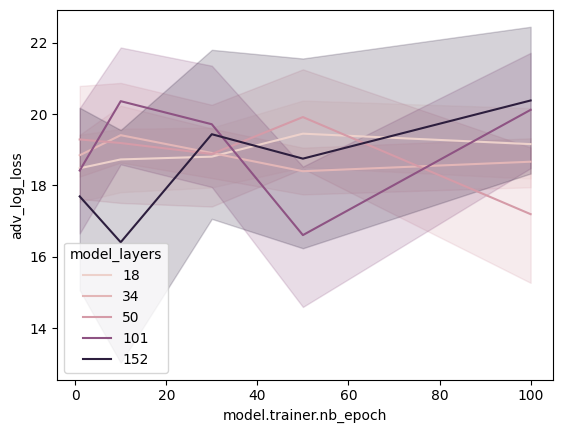

In [4]:
sns.lineplot(data=df, y="adv_log_loss", x="model.trainer.nb_epoch", hue="model_layers")

In [5]:
from lifelines import (
    CoxPHFitter,
    KaplanMeierFitter,
    NelsonAalenFitter,
    AalenAdditiveFitter,
    WeibullAFTFitter,
    LogNormalAFTFitter,
    LogLogisticAFTFitter,
    PiecewiseExponentialRegressionFitter,
)


model_dict = {
    "cox": CoxPHFitter,
    # "kaplan_meier" : KaplanMeierFitter,
    # "nelson_aalen" : NelsonAalenFitter,
    # "aalen_additive" : AalenAdditiveFitter,
    "weibull": WeibullAFTFitter,
    "log_normal": LogNormalAFTFitter,
    "log_logistic": LogLogisticAFTFitter,
    # "piecewise_exponential" : PiecewiseExponentialRegressionFitter,
}


def fit_aft_model(df, sense_dict, model_name):
    stratify = [
        "atk_gen",
        "def_gen",
    ]
    subset_df = df.copy()
    subset_df = subset_df.drop(stratify, axis=1)
    model = model_dict[model_name]()
    model.fit(df, duration_col="mean_adv_fit_time", event_col="adv_failures")
    model.print_summary()
    plot = model.plot()
    concordance = model.score(df, scoring_method="concordance_index")
    print(f"Concordance index: {concordance}")
    measured_median = np.median(
        df.mean_adv_fit_time / df["attack.attack_size"] * ((1 - df.adv_failures) / 100)
    )
    print("Measured median attack time:", measured_median)
    modelled_median = np.median(model.predict_median(df, ancillary=df))
    print("Predicted median attack time:", modelled_median)
    score = model.score(df, scoring_method="log_likelihood")
    score_dict = {
        "model": model_name,
        "concordance": concordance,
        "measured_median": measured_median,
        "modelled_median": modelled_median,
        "log_likelihood": score,
    }
    return model, plot, score


models = {}
scores = {}
plots = {}
stratify = ["atk_gen", "def_gen"]
subset_cols = [k for k in sense_dict if k not in stratify]
aft_df = df[subset_cols].copy()
aft_df["adv_failures"] = (1 - df["mean_adv_accuracy"]) * df["attack.attack_size"]
del aft_df["mean_adv_accuracy"]
new_sense_dict = sense_dict.copy()
new_sense_dict.update({"adv_failures": sense_dict["mean_adv_accuracy"]})
new_sense_dict.pop("mean_adv_accuracy", None)
new_sense_dict

for model_name in model_dict:
    print(f"Fitting {model_name} model")
    model, plot, score = fit_aft_model(aft_df, new_sense_dict, model_name)
    models.update({model_name: model})
    scores.update({model_name: score})
    plots.update({model_name: plot})
    plt.xscale("linear")
    plt.show()
    plt.gcf().clear()

# scores = pd.DataFrame.from_dict(scores, orient='index', columns=['score'])

# covariates = [k for k,v in sense_dict.items() if v == 'diff']
# values = [np.array(df[k].unique()) for k in covariates]
# print(f"Number of covariates: {len(covariates)}")
# print(f"Number of values: {len(values)}")
# print(f"Values: \n{[value.tolist() for value in values]}")
# for i in range(len(covariates)):
#     if covariates[i] in stratify:
#         continue
#     else:
#         print(f"Plotting {covariates[i]} with values {values[i]}")
#         graph = model.plot_partial_effects_on_outcome(covariates = covariates[i], values =values[i], cmap='coolwarm', figsize=(10, 10))
#         print(type(graph))

Fitting cox model


KeyError: "['atk_gen', 'def_gen'] not found in axis"

In [ ]:
model = models["weibull"]
expectations = model.predict_expectation(df, ancillary=df)
survival_function = model.predict_survival_function(df, ancillary=df)

In [ ]:
scores.T

In [ ]:
df